## Goal

Expand the model to include planned and unplanned downtime. 
1. Model planned downtime, such as lunch hour or cafeteria break.
2. Model unplanned downtime, such as an emergency.

## I. Planned Downtime

Replace ```Resource()``` with ```PriorityResource()```. Define a lunch process to run in parallel with the main dietary consultation process. This process will block a resource by requesting capacity at higher priority. Such a request is possible with a resource of prioritizable type. In effect, lunch is a higher priority than consultation to enable a scheduled lunch break. **However, requested capacity will be allocated to a higher priority request only when released from any lower-priority process in progress.**

Define class ```Break4Lunch``` with the generator function to block the dietician's time during lunch hour. Find the implementation in method ```generate_lunch()``` where a resource ('worker') is requested and then rendered unavailable for the duration of lunch break. Note that a resource that is engaged by a lower priority process will *not* be bumped off mid-stride, it will be reallocated once released and then blocked for a time from requests lower in priority . Contrast with ```PreemptiveResource()``` which is snatched up regardless. However, **```PreemptiveResource()``` caused a bug in code, hence preferred ```PriorityResource()``` and no attempt to use preemption any further.**

We will need to ensure resumption of the main (dietary consultation) process in case a resource (i.e. the dietician) is pulled away from a patient during a consulation. Wrap a while loop around a request for resource in the method ```generate_consulation()``` of class ```Consultation```.  Calculate the processing time and initialize the processing time remaining to this value outside the while loop. The while loop is conditional upon the processing time remaining being greater than zero.  Inside the loop, request the resource and then handle the timeout for processing in a try-catch statement. Simpy raises an exception of class ```simpy.Interrupt``` to interrupt processing an entity. Catch this exception, recalculating the processing time remaining in ```catch``` block and continuing the while loop until the requested capacity is available again to finish where left off. In the ```try``` block, set the processing time to zero after the yield to timeout to terminate the while loop.  

We will continue to have resource monitoring in place for this enhancement. 

In [1]:
# Preliminaries
from dietician_monitor import G, Patient, Consultation, patch_resource, get_monitor, Break4Lunch, Break2Schedule
from plotnine import *
from numpy import linspace, sin, cos, pi, vectorize, append, array, asarray, trapz
import pandas as pd

In [2]:
G.number_of_dieticians = 2
G.simulation_horizon = 512
c = Consultation()
b = Break4Lunch(c.env, c.dietician, 20)
sim_res = c.run_once()


Patient 1 entered the queue at 0.00
Patient 1 entered consultation at 0.00, having waited 0.00
Patient 1 exited at 10.93, having spent 10.93 in clinic.
Patient 2 entered the queue at 19.90
Patient 2 entered consultation at 19.90, having waited 0.00
Gone to lunch at 20.00, break hour is 20.00.
Patient 3 entered the queue at 20.65
Patient 2 exited at 20.99, having spent 1.09 in clinic.
Gone to lunch at 20.99, break hour is 20.00.
Patient 4 entered the queue at 22.35
Patient 5 entered the queue at 26.45
Patient 6 entered the queue at 29.35
Patient 7 entered the queue at 34.33
Patient 8 entered the queue at 38.89
Back from lunch at 40.00 and open for business.
Patient 3 entered consultation at 40.00, having waited 19.35
Patient 9 entered the queue at 40.49
Back from lunch at 40.99 and open for business.
Patient 4 entered consultation at 40.99, having waited 18.63
Patient 3 exited at 41.78, having spent 21.13 in clinic.
Patient 5 entered consultation at 41.78, having waited 15.33
Patient 5 

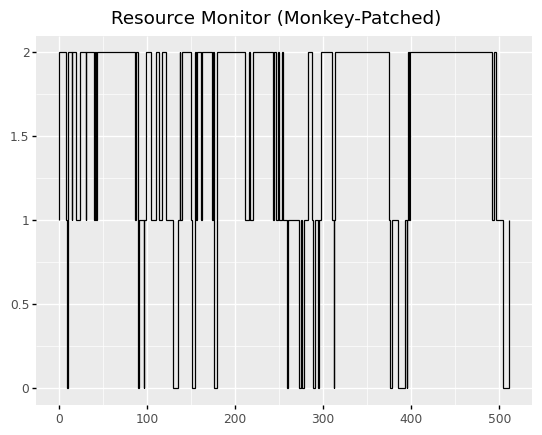

<ggplot: (317999336)>

In [7]:
x_monkey, y_monkey, _ = list(zip(*G.resource_monitor["dietician"]))
pMonkey = ggplot(aes(x=x_monkey, y=y_monkey)) \
            + geom_step() \
            + xlim(0, G.simulation_horizon) \
            + ggtitle("Resource Monitor (Monkey-Patched)")
pMonkey

In [8]:
avaUtil = G.number_of_dieticians * x_monkey[-1]
netUtil = trapz(y_monkey, x_monkey) 
percUtil = netUtil / avaUtil * 100
print("Dietician reported percentage utilization of {:.2f}={:.2f}/{:.2f}".format(percUtil, netUtil, avaUtil))
print("Dietician reported percentage utilization of {:.2f} from run metrics".format(sim_res.get("utilization")*100))

Dietician reported percentage utilization of 79.69=815.15/1022.92
Dietician reported percentage utilization of 79.69 from run metrics


*Scheduled Breaks*

Now we will extend this to scheduled breaks. Note that this approach adds one process per resource per break. This may seem like significant overhead, but it follows from Simpy's treatment of resource as an undifferentiated bulk. So we cannot differentiate among dieticians in the the dietician pool with a number of dieticians. When a dietician is requested or released, there is no unique label or ID to identify which one.

Define class ```Break2Schedule``` with helper method ```break_generator()``` to request a resource for blocking for a given time interval. The method implements a generator function and accepts one break (specified by start and duration) via arguments. It spawns a process that schedules the break for each dietician. The method ```generate_breaks()``` uses the helper method in a for loop, iterating over each break in the schedule.

This approach has one process for each break for each dietician. This is unavoidable as explained above. 

In [5]:
G.number_of_dieticians = 2
G.simulation_horizon = 512
cc = Consultation()
bs = Break2Schedule(cc.env, cc.dietician, [(10, 5), (30, 5)])
sim_res = cc.run_once()

10 : 5
10 : 5
30 : 5
30 : 5
Patient 1 entered the queue at 0.00
Patient 1 entered consultation at 0.00, having waited 0.00
Patient 2 entered the queue at 0.21
Patient 2 entered consultation at 0.21, having waited 0.00
Patient 3 entered the queue at 2.85
Patient 1 exited at 4.87, having spent 4.87 in clinic.
Patient 3 entered consultation at 4.87, having waited 2.02
Patient 3 exited at 7.99, having spent 5.14 in clinic.
Patient 2 exited at 9.54, having spent 9.33 in clinic.
Gone on break at 10.00 for scheduled break at 10.00
Gone on break at 10.00 for scheduled break at 10.00
Patient 4 entered the queue at 10.13
Patient 5 entered the queue at 10.97
Patient 6 entered the queue at 11.72
Break ended, back in business at 15.00.
Break ended, back in business at 15.00.
Patient 4 entered consultation at 15.00, having waited 4.87
Patient 5 entered consultation at 15.00, having waited 4.03
Patient 4 exited at 15.87, having spent 5.75 in clinic.
Patient 6 entered consultation at 15.87, having wai

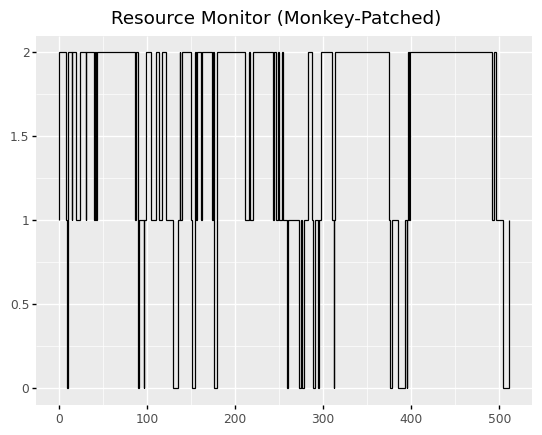

<ggplot: (318048702)>

In [9]:
x_monkey, y_monkey, _ = list(zip(*G.resource_monitor["dietician"]))
pMonkey = ggplot(aes(x=x_monkey, y=y_monkey)) \
            + geom_step() \
            + xlim(0, G.simulation_horizon) \
            + ggtitle("Resource Monitor (Monkey-Patched)")
pMonkey

In [10]:
G.number_of_dieticians = 2
G.simulation_horizon = 512
ccc = Consultation(shift_length=150)
b2s = Break2Schedule(ccc.env, ccc.dietician, [(10, 5), (30, 5)])
sim_res = ccc.run_once()

10 : 5
10 : 5
30 : 5
30 : 5
Patient 1 entered the queue at 0.00
Patient 1 entered consultation at 0.00, having waited 0.00
Patient 2 entered the queue at 0.11
Patient 2 entered consultation at 0.11, having waited 0.00
Patient 3 entered the queue at 1.44
Patient 1 exited at 2.70, having spent 2.70 in clinic.
Patient 3 entered consultation at 2.70, having waited 1.26
Patient 4 entered the queue at 2.75
Patient 2 exited at 3.79, having spent 3.68 in clinic.
Patient 4 entered consultation at 3.79, having waited 1.04
Patient 3 exited at 5.75, having spent 4.31 in clinic.
Patient 4 exited at 7.02, having spent 4.27 in clinic.
Patient 5 entered the queue at 7.91
Patient 5 entered consultation at 7.91, having waited 0.00
Gone on break at 10.00 for scheduled break at 10.00
Patient 6 entered the queue at 10.04
Break ended, back in business at 15.00.
Gone on break at 15.00 for scheduled break at 10.00
Patient 5 exited at 15.99, having spent 8.08 in clinic.
Patient 6 entered consultation at 15.99,

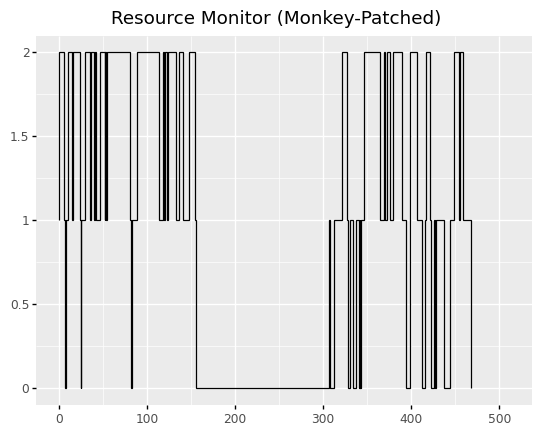

<ggplot: (281018435)>

In [11]:
x_monkey, y_monkey, _ = list(zip(*G.resource_monitor["dietician"]))
pMonkey = ggplot(aes(x=x_monkey, y=y_monkey)) \
            + geom_step() \
            + xlim(0, G.simulation_horizon) \
            + ggtitle("Resource Monitor (Monkey-Patched)")
pMonkey